In [1]:
import glob
import os
from os.path import exists
from xml.etree import ElementTree

In [2]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder

In [3]:
IMAGES_PATH = "resources/Images"
CROPPED_IMAGES_PATH = "resources/Cropped_Images"

In [4]:
def extract_information_from_annotations(image_path):
    annotation_path = image_path.replace("Images", "Annotation").replace(".jpg", "")
    
    tree = ElementTree.parse(annotation_path)
    x_min = int(list(tree.iter('xmin'))[0].text)
    x_max = int(list(tree.iter('xmax'))[0].text)
    y_min = int(list(tree.iter('ymin'))[0].text)
    y_max = int(list(tree.iter('ymax'))[0].text)
    race = list(tree.iter('name'))[0].text.lower()
    
    return (x_min, y_min, x_max, y_max), race

In [5]:
def extract_cropped_images():
    os.makedirs(CROPPED_IMAGES_PATH, exist_ok=True)
    
    for image_path in glob.glob(f'{IMAGES_PATH}/*/*.jpg'):
        dimensions, race = extract_information_from_annotations(image_path)
        
        original_image = Image.open(image_path)
        cropped_image = original_image.crop(dimensions)
        cropped_image_path = f"{CROPPED_IMAGES_PATH}/{race}/" + image_path.split("/")[-1]
        
        os.makedirs(cropped_image_path.replace(image_path.split("/")[-1], ""), exist_ok=True)
        
        try:
            cropped_image.save(cropped_image_path)
        except OSError as e:
            if e.args == ('cannot write mode RGBA as JPEG',):
                print(f"Converting {cropped_image_path} to RGB.")
                cropped_image = cropped_image.convert('RGB')
                cropped_image.save(cropped_image_path)
                
    print(f"All cropped images have been extracted and saved under:{CROPPED_IMAGES_PATH}.\n")

In [6]:
def load_image(row):
    return cv2.imread(row['image_path'], 1)

In [7]:
def load_images():
    images_df = DataFrame()
    
    all_images = list(glob.glob(f"{CROPPED_IMAGES_PATH}/*/*.jpg"))
    images_df["image_path"] = all_images
    
    images_df["image"] = images_df.apply(load_image, axis=1)
    images_df["label_name"] = images_df["image_path"].apply(lambda path: path.split("/")[-2].lower())
    
    labels = [f.path.split("/")[-1].lower() for f in os.scandir(CROPPED_IMAGES_PATH) if f.is_dir()]
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    images_df["label"] = label_encoder.transform(images_df["label_name"])
    
    return images_df

In [8]:
def print_images_dimensions(images_df):
    dimensions = []
    
    for image_path in images_df[['image_path']].values:
        image = Image.open(image_path[0])
        width, height = image.size
        dimensions.append({"width": width, "height": height})
        
    dimensions_df = DataFrame(dimensions)
    print(dimensions_df.describe())
    print("\n")

In [9]:
def resize_image(row):
    return cv2.resize(row['image'], (224, 224))

In [10]:
def convert_image_to_grayscale(row):
    return cv2.cvtColor(row['resized_image'], cv2.COLOR_BGR2GRAY)

In [11]:
def denoise_image(row):
    return cv2.fastNlMeansDenoising(row['grayscaled_image'], None, 10, 7, 21)

In [12]:
def equalize_histogram(row):
    return cv2.equalizeHist(row['grayscaled_image'])

In [13]:
def display_images_count_per_label(images_df):
    counts = []
    for label in images_df['label_name'].unique():
        counts.append({"label": label, "count": len(images_df[images_df['label_name'] == label])})
        
    counts_df = DataFrame(counts).sort_values("label")
    counts_plot = (counts_df.plot(kind="line", x="label", figsize=(15, 8), rot=0,
                                   title=f"Count of images per label"))
    
    mean_count = sum(count['count'] for count in counts) / len(counts)
    plt.axhline(y=mean_count, color='g', linestyle='-')
    plt.yticks(list(plt.yticks()[0]) + [mean_count])
    
    counts_plot.title.set_size(20)
    counts_plot.set(xlabel=None)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.gca().get_legend().remove()
    
    plt.show()
    plt.close()

Starting analysis and preprocessing script.

20580 images have been loaded with 120 different labels.

Displaying now the count of images per label.



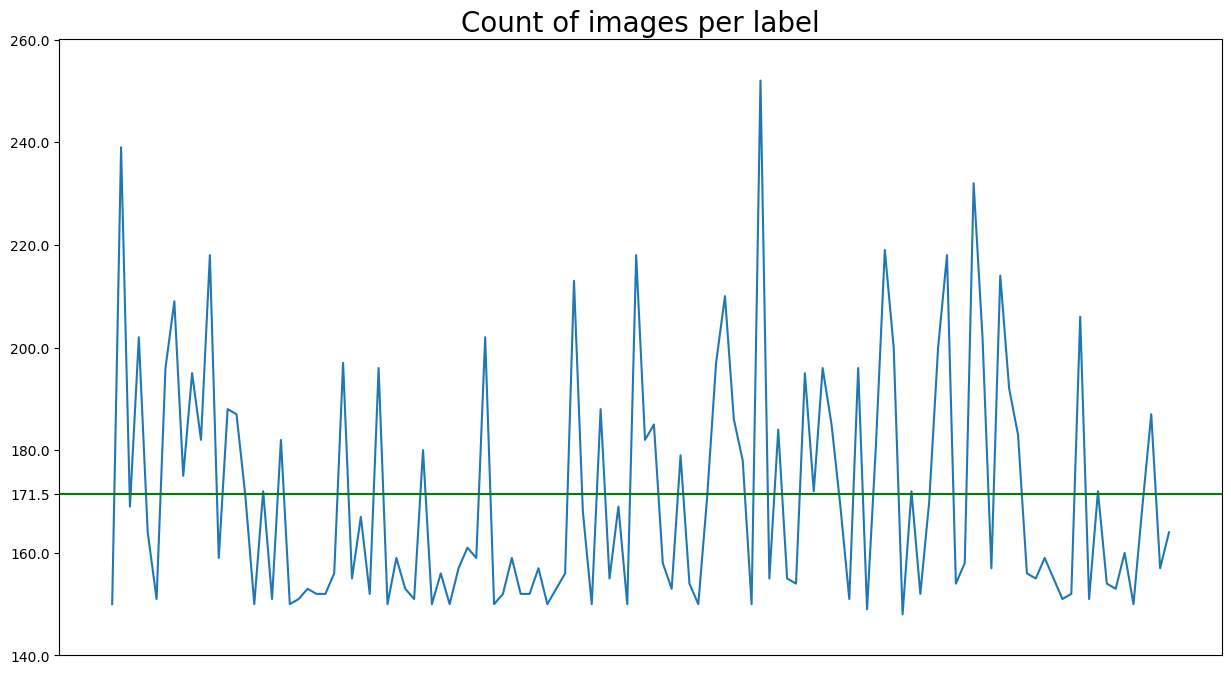

Displaying now the dimensions of the images.

              width        height
count  20580.000000  20580.000000
mean     289.040671    297.629932
std      128.577818    119.853244
min       32.000000     38.000000
25%      200.000000    220.000000
50%      279.000000    291.000000
75%      362.000000    357.000000
max     2735.000000   2025.000000


Creating now resized images.

Creating now grayscaled images.

Creating now denoised images.

Creating now equalized images.

Displaying different states of image number:1.



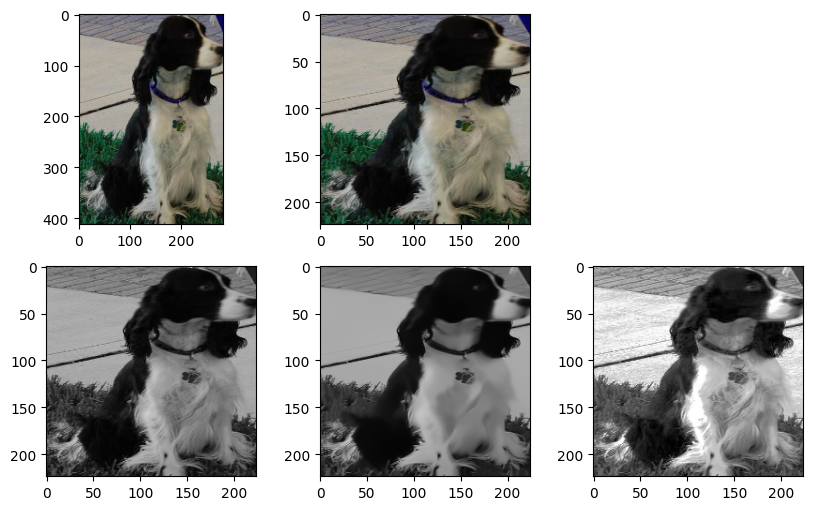

Displaying different states of image number:2.



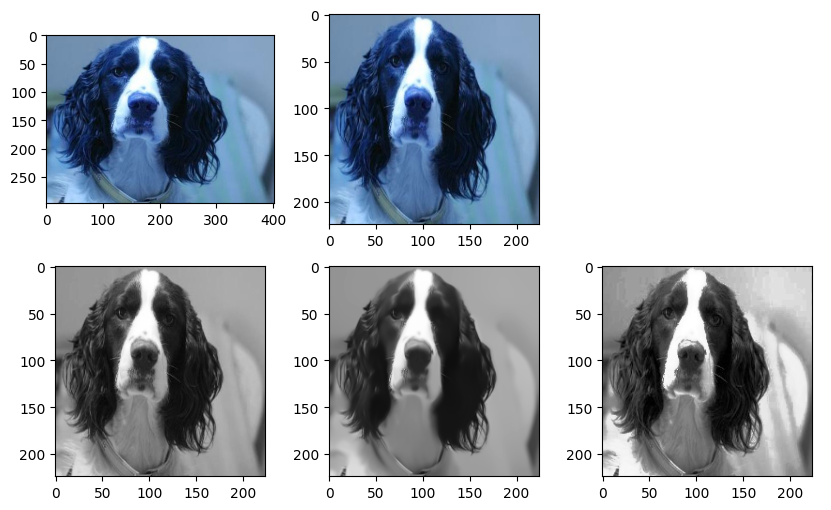

Displaying different states of image number:3.



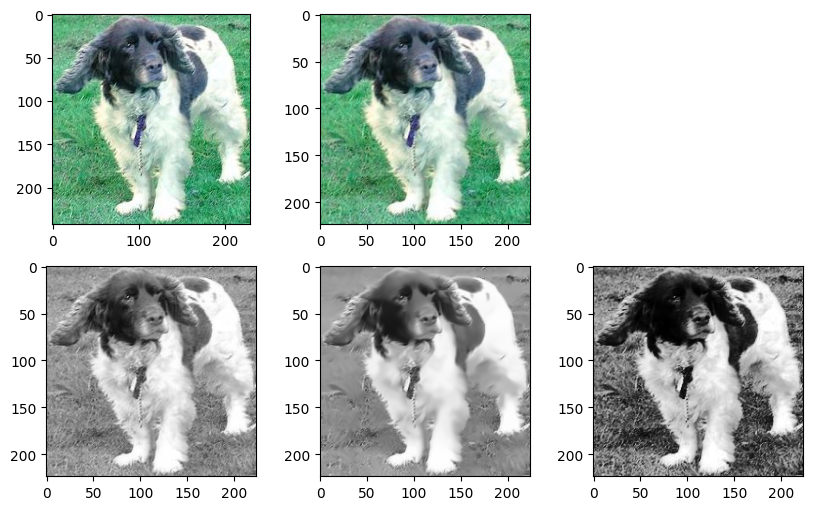

Displaying different states of image number:4.



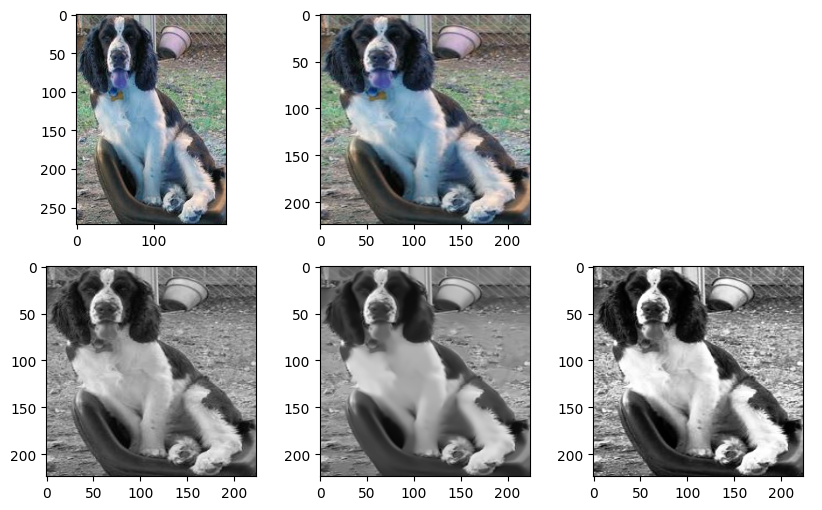

Displaying different states of image number:5.



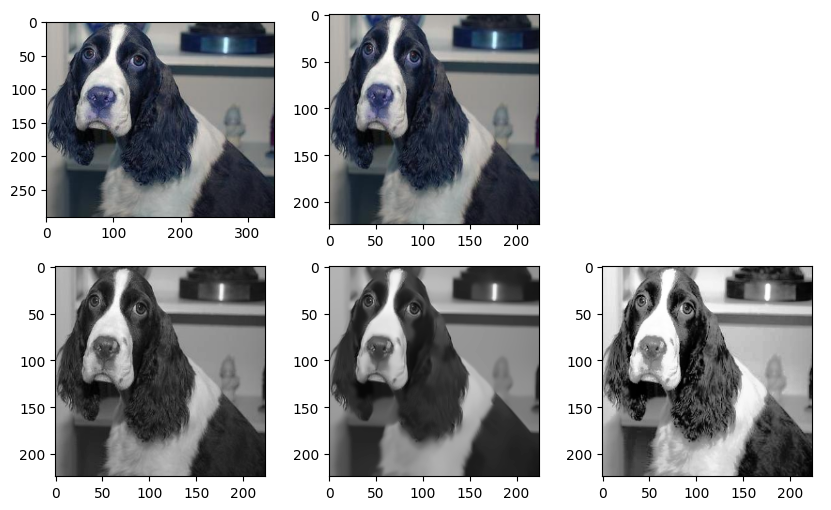

Analysis and preprocessing script finished.



In [14]:
if __name__ == '__main__':
    print("Starting analysis and preprocessing script.\n")
    
    if not exists(CROPPED_IMAGES_PATH):
        extract_cropped_images()
        
    images_df = load_images()
    print(f"{len(images_df)} images have been loaded with {len(images_df['label_name'].unique())} different labels.\n")

    print("Displaying now the count of images per label.\n")
    display_images_count_per_label(images_df)

    print("Displaying now the dimensions of the images.\n")
    print_images_dimensions(images_df)
    
    images_df = images_df.head(5)
    
    print("Creating now resized images.\n")
    # Resizing image to fit the 224x224 input size of most models
    images_df["resized_image"] = images_df.apply(resize_image, axis=1)
    
    print("Creating now grayscaled images.\n")
    # Conversion of the image to grayscale as color is not a relevant information in race detection
    images_df["grayscaled_image"] = images_df.apply(convert_image_to_grayscale, axis=1)
    
    print("Creating now denoised images.\n")
    # Denoise image to improve its quality and reduce the impact of noise on the model
    images_df["denoised_image"] = images_df.apply(denoise_image, axis=1)
    
    print("Creating now equalized images.\n")
    # Equalize the histogram of the image to improve the contrast and make the features more visible
    images_df["equalized_image"] = images_df.apply(equalize_histogram, axis=1)
    
    for image_index in range(0, len(images_df)):
        print(f"Displaying different states of image number:{image_index + 1}.\n")
        image = images_df.iloc[image_index]

        f, ax = plt.subplots(2, 3, figsize=(10, 6))
        ax[0, 0].imshow(image['image'])
        ax[0, 1].imshow(image['resized_image'])
        ax[0, 2].axis('off')
        ax[1, 0].imshow(image['grayscaled_image'], cmap='gray', vmin=0, vmax=255)
        ax[1, 1].imshow(image['denoised_image'], cmap='gray', vmin=0, vmax=255)
        ax[1, 2].imshow(image['equalized_image'], cmap='gray', vmin=0, vmax=255)

        plt.show()
        plt.close()
        
    print("Analysis and preprocessing script finished.\n")